In [15]:
import os
import scipy
import numpy as np
import pandas as pd
from numpy.linalg import multi_dot

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from nilearn.connectome import ConnectivityMeasure

In [8]:
inputdir = 'C:/GitHub/CNI_challenge_2019/cni_challenge/inputdir'
# outputdir = './outputdir'

In [9]:
def _load_fmri(sub_ids, path, atlas='cc200'):
    """Load time-series extracted from the fMRI using a specific atlas."""
    return [pd.read_csv(os.path.join(path,'%s/timeseries_%s.csv'%(sub_id, atlas)), 
                        header=None).values.T
                     for sub_id in sub_ids]

In [10]:
def _load_data(partition='Training', atlas='cc200'):    
    pheno_path = os.path.join(inputdir, 'SupportingInfo/phenotypic_%s.csv'%partition.lower())
    
    pheno_df = pd.read_csv(pheno_path)
    
    data = _load_fmri(pheno_df['Subj'], os.path.join(inputdir, partition), atlas=atlas)
    
    pheno_df_ = pheno_df.copy()
    
    for i in pheno_df_.index.values:
        if pheno_df_.loc[i,'DX'] == 'ADHD':
            pheno_df_.loc[i,'DX'] = 1
        else:
            pheno_df_.loc[i,'DX'] = -1
            
    return data, pheno_df_

In [11]:
def get_data(kind='tangent', atlas='cc200', return_pheno=False):
    pheno_path = os.path.join(inputdir, 'pheno.csv')
    
    data_path = os.path.join(inputdir, 'X_%s_%s.npy'%(atlas, kind))
    
    if os.path.exists(data_path):
        X = np.load(data_path)
    else:
        X_train, pheno_train = get_train_data(atlas=atlas)
        X_valid, pheno_valid = get_valid_data(atlas=atlas)
        X_all = X_train + X_valid
        measure = ConnectivityMeasure(kind=kind, vectorize=True)
        X_connectome = measure.fit_transform(X_all)
        n_roi = X_all[0].shape[1]
        n_sub = len(X_all)
        X_ = np.zeros((n_sub, n_roi*2))
        for i in range(n_sub):
            X_[i,:n_roi] = np.mean(X_all[i], axis=0)
            X_[i,n_roi:] = np.std(X_all[i], axis=0)
        X = np.concatenate((X_, X_connectome), axis=1)
        np.save(data_path, X)
        if not os.path.exists(pheno_path):
            pheno = pd.concat([pheno_train, pheno_valid])
            pheno.to_csv(pheno_path, index=False)
    pheno = pd.read_csv(pheno_path)
    if return_pheno:
        return X, pheno
    else:
        return X

In [12]:
def get_train_data(atlas='cc200'):
    return _load_data(partition='Training', atlas=atlas)


def get_valid_data(atlas='cc200'):
    return _load_data(partition='Validation', atlas=atlas)

## Import time series data

In [17]:
X_train, pheno_train = get_train_data(atlas='aal')
X_valid, pheno_valid = get_valid_data(atlas='aal')

### Visualise time series

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

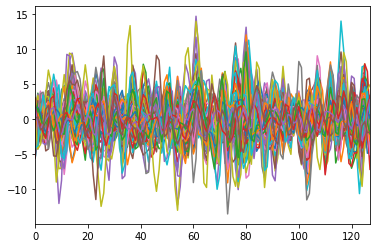

In [23]:
pd.DataFrame(X_train[1]).plot(legend=False)
plt.show()

## Extract brain network features

### Pearson correlation connectivity analysis

In [24]:
measure = ConnectivityMeasure(kind='correlation')
X_all = X_train + X_valid
X_cor = measure.fit_transform(X_all)

### Visualise Pearson correlation connectivity matrix

In [25]:
from nilearn import plotting

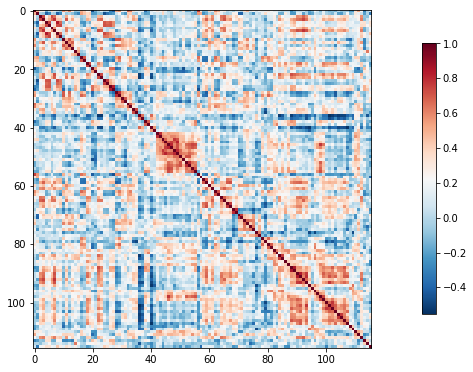

In [31]:
plotting.plot_matrix(X_cor[1])

### Tangent (group-level) connectivity analysis

In [27]:
# measure = ConnectivityMeasure(kind='tangent', vectorize=True)
measure = ConnectivityMeasure(kind='tangent')
X_ = measure.fit_transform(X_cor)

### Visualise tangent connectivity matrix

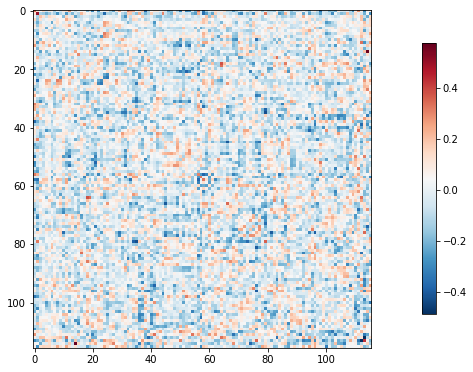

In [32]:
plotting.plot_matrix(X_[1])

### Compare with tangent only

In [33]:
Xtan = measure.fit_transform(X_all)

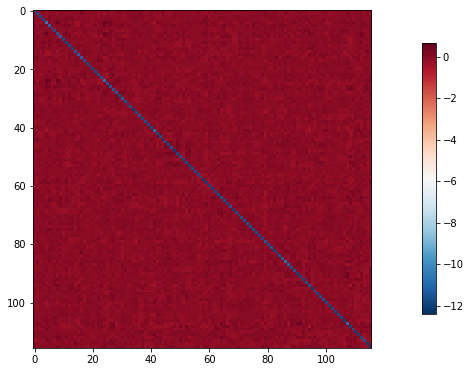

In [36]:
plotting.plot_matrix(Xtan[1])

In [37]:
measure = ConnectivityMeasure(kind='covariance')
Xcov = measure.fit_transform(X_all)

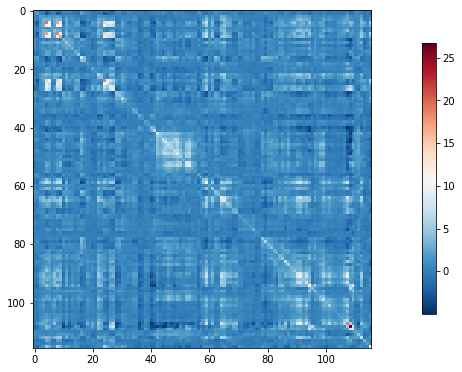

In [38]:
plotting.plot_matrix(Xcov[1])

### Side inforamtion dependence as a regulariser (SIDeR) framework

$$
\min_{f} \ \underbrace{\mathcal{L}(f(\mathbf{X}^l), \mathbf{Y}) + \sigma \cdot \|f\|_2}_{\text{Prediction loss and }\ell_2 \text{ regularisation}} + \lambda \cdot \underbrace{\rho(f(\mathbf{X}), \mathbf{D})}_{\text{SIDeR}}
$$

$$
\min_{\mathbf{w}, \xi, b} \ \frac{1}{2}\mathbf{w}^\top\mathbf{K}\mathbf{w} \!+\! C\sum_i^{\tilde{n}}\xi_i \!+ \! \tilde{\lambda}\mathbf{w}^\top\mathbf{K HL}\mathbf{HK}\mathbf{w}, \\
    \mathrm{s.t.}\:\:  y_i (\mathbf{w}^\top\mathbf{k}_i+b)\geq1-\xi_i, \: \xi_i\geq 0, \: i=1,\dots,\tilde{n},
$$